# Introduction

In this notebook, we explore automated clustering of mental health research abstracts. Our objective is to streamline the literature review process by grouping abstracts into meaningful clusters that correspond to different mental health disorders. 

To achieve this, we:
- **Leverage Text Embeddings:** Utilize BERT and GloVe embeddings to represent the semantic content of abstracts.
- **Apply Clustering Algorithms:** Experiment with KMeans, Agglomerative Clustering, and Gaussian Mixture Models to group similar abstracts.
- **Evaluate Performance:** Use evaluation metrics such as Cohen's Kappa, Silhouette Score, and Coherence Score to assess both the accuracy and semantic consistency of our clusters.

This approach aims to facilitate quick identification of relevant research, providing a robust framework for researchers in the mental health domain.

**Dataset Used:**  
We use a dataset of research paper abstracts scraped from PubMed, containing abstracts labeled with 1000 rows with two columns: "Label" (the disorder category) and "Abstract" (the 150-word text partition).





# 1. Data Loading and Preprocessing

In this section, we load our dataset and perform initial preprocessing steps, such as reading the CSV file and preparing text for embedding.

In [30]:
import pandas as pd
from nltk.corpus import stopwords
import numpy as np
from sentence_transformers import SentenceTransformer
from gensim.models import KeyedVectors
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, cohen_kappa_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
import re
import string
from nltk.tokenize import word_tokenize

In [31]:
nltk.download('stopwords')
df = pd.read_csv("scraped_pubmed_abstract_150 1.csv")
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return " ".join(filtered_tokens)

# Apply the function to the 'text' column and create a new column 'text_clean'
df['Abstract'] = df['Abstract_unclean'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shebon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Label,Abstract_unclean,Abstract
0,clinical depression,Although anxiety and depression have been cons...,Although anxiety depression considered two dis...
1,clinical depression,ObjectiveAdolescence is a formative and turbul...,ObjectiveAdolescence formative turbulent phase...
2,clinical depression,Major depressive disorder MDD is considered a ...,Major depressive disorder MDD considered serio...
3,clinical depression,BackgroundBurnout and clinical depression have...,BackgroundBurnout clinical depression variably...
4,clinical depression,The interaction of physical and mental vulnera...,interaction physical mental vulnerability envi...


In [32]:
df.shape

(1000, 3)

In [33]:
df['Abstract']

0      Although anxiety depression considered two dis...
1      ObjectiveAdolescence formative turbulent phase...
2      Major depressive disorder MDD considered serio...
3      BackgroundBurnout clinical depression variably...
4      interaction physical mental vulnerability envi...
                             ...                        
995    BackgroundComparisons illness characteristics ...
996    tendency towards schizophrenia average UD pati...
997    BackgroundMedication used acute aggression psy...
998    tranquillisation Compared haloperidol zuclopen...
999    getting blurred visiondry mouth n RCTs RR hour...
Name: Abstract, Length: 1000, dtype: object

In [34]:
category_counts = df['Label'].value_counts()
print(category_counts)

Label
clinical depression               200
bipolar disorder                  200
anxiety disorder                  200
post-traumatic stress disorder    200
schizophrenia                     200
Name: count, dtype: int64


In [35]:
df["Label_num"] = df["Label"].astype("category").cat.codes
df["Label_num"].unique()

array([2, 1, 0, 3, 4], dtype=int8)

# 2. Embedding Generation

We generate embeddings using two methods: BERT-based Sentence Transformer and GloVe. These embeddings are stored as new columns in the DataFrame.

In [36]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')
# Load BERT-based Sentence Transformer model
bert_model = SentenceTransformer("all-MiniLM-L6-v2")
df["bert_vector"] = df["Abstract"].astype(str).apply(lambda x: bert_model.encode(x))

# Load GloVe embeddings
def load_glove_embeddings(glove_file_path):
    glove_model = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_model[word] = vector
    return glove_model

def clean_text(text):
    """
    Clean text by lowercasing, removing punctuation, and extra whitespace.
    """
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


stop_words = set(stopwords.words('english'))

def get_glove_vector(abstract, glove_model, vector_size=100):
    """
    Compute the average GloVe vector for a given abstract after cleaning, tokenization,
    and stop word removal.
    """
    # Clean the text: lowercase and remove punctuation
    text_clean = abstract.lower()
    text_clean = re.sub(f"[{re.escape(string.punctuation)}]", "", text_clean)
    text_clean = re.sub(r"\s+", " ", text_clean).strip()

    # Tokenize and remove stop words
    tokens = word_tokenize(text_clean)
    tokens = [token for token in tokens if token not in stop_words]

    # Get GloVe vectors for tokens that exist in the GloVe model
    vectors = [glove_model[word] for word in tokens if word in glove_model]

    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Load GloVe model
glove_model = load_glove_embeddings('glove.6B.100d.txt')

# Generate GloVe embeddings for each abstract
df["glove_vector"] = df["Abstract"].apply(lambda x: get_glove_vector(x, glove_model))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shebon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Shebon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shebon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:

# Convert the embeddings to numpy arrays
X_glove = np.vstack(df["glove_vector"].values)
X_bert = np.vstack(df["bert_vector"].values)

# Combine both embeddings
X_combined = np.hstack([X_glove, X_bert])


In [38]:

# Normalize the combined embeddings
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# 3. Clustering and Evaluation

Here, we apply clustering algorithms (KMeans, Agglomerative Clustering, and GMM) on the embeddings. We then align the cluster labels with the true labels and compute evaluation metrics (Silhouette Score and Cohen's Kappa Score).

In [39]:
# Function to run clustering and evaluate models
def evaluate_clustering(X_scaled, df):
    num_clusters = df["Label_num"].nunique()

    # Perform clustering with KMeans, Agglomerative, and GMM
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    # Remove affinity='euclidean' for linkage='ward'
    agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    gmm = GaussianMixture(n_components=num_clusters, random_state=42)

    df["kmeans_cluster"] = kmeans.fit_predict(X_scaled)
    df["agg_cluster"] = agg_clustering.fit_predict(X_scaled)
    df["gmm_cluster"] = gmm.fit_predict(X_scaled)

    # Align the labels using the Hungarian algorithm (linear sum assignment)
    def align_labels(true_labels, pred_labels):
        cm = confusion_matrix(true_labels, pred_labels)
        row_ind, col_ind = linear_sum_assignment(-cm)  # maximize by minimizing negative confusion matrix
        mapping = {pred: true for true, pred in zip(row_ind, col_ind)}
        aligned = np.array([mapping.get(label, label) for label in pred_labels])
        return aligned

    # Align labels for clustering results
    df["kmeans_aligned"] = align_labels(df["Label_num"], df["kmeans_cluster"])
    df["agg_aligned"] = align_labels(df["Label_num"], df["agg_cluster"])
    df["gmm_aligned"] = align_labels(df["Label_num"], df["gmm_cluster"])

    # Calculate evaluation metrics (Silhouette Score and Kappa Score)
    silhouette_kmeans = silhouette_score(X_scaled, df["kmeans_aligned"])
    silhouette_agg = silhouette_score(X_scaled, df["agg_aligned"])
    silhouette_gmm = silhouette_score(X_scaled, df["gmm_aligned"])

    kappa_kmeans = cohen_kappa_score(df["Label_num"], df["kmeans_aligned"])
    kappa_agg = cohen_kappa_score(df["Label_num"], df["agg_aligned"])
    kappa_gmm = cohen_kappa_score(df["Label_num"], df["gmm_aligned"])

    return silhouette_kmeans, silhouette_agg, silhouette_gmm, kappa_kmeans, kappa_agg, kappa_gmm

In [40]:
# Loop through BERT, GloVe, and Combined embeddings, evaluate, and compare results
results = {}

# BERT Embeddings
X_bert_scaled = scaler.fit_transform(X_bert)
results['BERT'] = evaluate_clustering(X_bert_scaled, df)

# GloVe Embeddings
X_glove_scaled = scaler.fit_transform(X_glove)
results['GloVe'] = evaluate_clustering(X_glove_scaled, df)

# Combined Embeddings
X_combined_scaled = scaler.fit_transform(X_combined)
results['Combined'] = evaluate_clustering(X_combined_scaled, df)


C:\Users\Shebon\anaconda3\envs\Data_Science_NLP\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Shebon\anaconda3\envs\Data_Science_NLP\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Shebon\anaconda3\envs\Data_Science_NLP\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Shebon\anaconda3\envs\Data_Science_NLP\lib\site-packages\s

In [41]:
# Compare Kappa scores and Silhouette scores
print("Evaluation Results (Kappa Scores and Silhouette Scores):")
for model in results:
    print(f"\n{model}:")
    print(f"Kappa Score (KMeans): {results[model][3]:.4f}")
    print(f"Kappa Score (Agglomerative): {results[model][4]:.4f}")
    print(f"Kappa Score (GMM): {results[model][5]:.4f}")
    print(f"Silhouette Score (KMeans): {results[model][0]:.4f}")
    print(f"Silhouette Score (Agglomerative): {results[model][1]:.4f}")
    print(f"Silhouette Score (GMM): {results[model][2]:.4f}")

Evaluation Results (Kappa Scores and Silhouette Scores):

BERT:
Kappa Score (KMeans): 0.9537
Kappa Score (Agglomerative): 0.9375
Kappa Score (GMM): 0.6625
Silhouette Score (KMeans): 0.1209
Silhouette Score (Agglomerative): 0.1172
Silhouette Score (GMM): 0.1037

GloVe:
Kappa Score (KMeans): 0.2788
Kappa Score (Agglomerative): 0.2812
Kappa Score (GMM): 0.2788
Silhouette Score (KMeans): 0.0788
Silhouette Score (Agglomerative): 0.0503
Silhouette Score (GMM): 0.0788

Combined:
Kappa Score (KMeans): 0.9550
Kappa Score (Agglomerative): 0.9313
Kappa Score (GMM): 0.6412
Silhouette Score (KMeans): 0.1044
Silhouette Score (Agglomerative): 0.0999
Silhouette Score (GMM): 0.0904


# 4. Error Analysis and Selecting the Champion model

In [42]:
method_names = ["KMeans", "Agglomerative", "GMM"]

best_model = None
best_method = None
best_kappa = float('-inf')

for model in results:
    # Kappa scores are in positions 3, 4, and 5 of the tuple
    kappa_scores = results[model][3:6]  # (kappa_kmeans, kappa_agg, kappa_gmm)
    local_best_kappa = max(kappa_scores)

    if local_best_kappa > best_kappa:
        best_kappa = local_best_kappa
        best_model = model
        best_method = method_names[kappa_scores.index(local_best_kappa)]

print(f"\nBest Model based on Kappa Score: {best_model}")
print(f"Best Clustering Method: {best_method}")
print(f"Highest Kappa Score: {best_kappa:.4f}")


Best Model based on Kappa Score: Combined
Best Clustering Method: KMeans
Highest Kappa Score: 0.9550


In [43]:
def analyze_misclustered(df, true_col, model_cols):
    misclustered = {}
    for col in model_cols:
        misclass = df[df[true_col] != df[col]]
        misclustered[col] = misclass
        print(f"misclustered by {col}: {len(misclass)} instances")
    return misclustered

model_cols = ['kmeans_aligned', 'agg_aligned', 'gmm_aligned']
misclustered_data = analyze_misclustered(df, 'Label_num', model_cols)

misclustered by kmeans_aligned: 36 instances
misclustered by agg_aligned: 55 instances
misclustered by gmm_aligned: 287 instances


In [44]:
from collections import Counter
# nltk.download('punkt')
# nltk.download('punkt_tab')

def get_top_words(text_series, n=10):
    text = " ".join(text_series.tolist())  # Join all text entries to one large string
    # Change Abstract to text_series
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.isalnum()]  # Filter out punctuation/numbers
    word_freq = Counter(filtered_words)
    return word_freq.most_common(n)

top_words_misclustered = get_top_words(misclustered['Abstract'])
print("Top 10 frequent words in misclustered texts:", top_words_misclustered)

Top 10 frequent words in misclustered texts: [('disorder', 49), ('studies', 46), ('depression', 41), ('clinical', 36), ('participants', 32), ('weight', 32), ('bipolar', 31), ('depressive', 29), ('outcomes', 29), ('study', 27)]


# 5. Visualization

We create plots to visualize evaluation metrics like Kappa and Coherence Scores (calculated towards the end) across different clustering methods and embeddings.

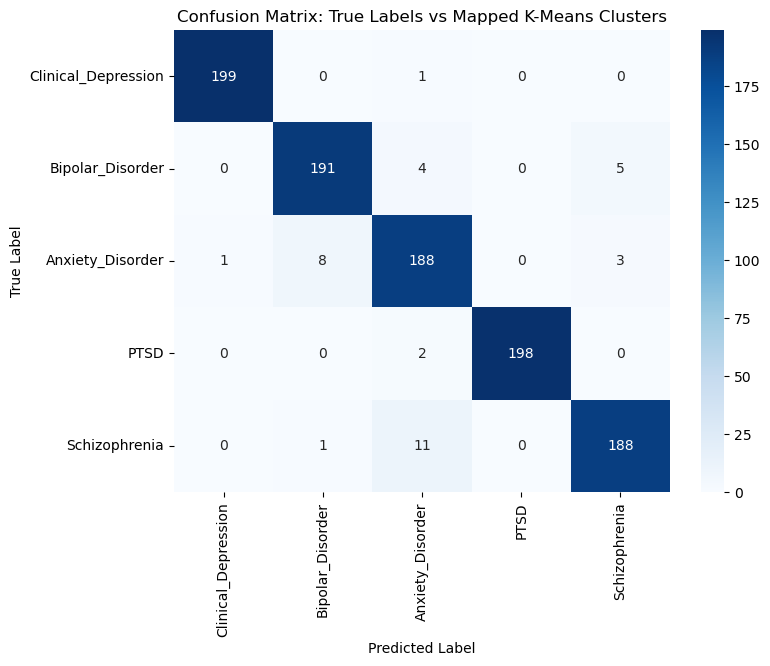

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Suppose your actual label names are stored in a list
label_names = ["Clinical_Depression", "Bipolar_Disorder", "Anxiety_Disorder", "PTSD", "Schizophrenia"]

# Assuming 'df' is your DataFrame and 'Label_num' is the column with true labels
true_labels = df['Label_num']  # Define true_labels using your DataFrame

# Assuming 'mapped_kmeans' represents the aligned KMeans cluster labels
mapped_kmeans = df['kmeans_aligned'] # Define mapped_kmeans if not already defined

# Compute confusion matrix using these label names
cmatrix = confusion_matrix(true_labels, mapped_kmeans, labels=np.unique(true_labels)) # Use np.unique to get unique labels

plt.figure(figsize=(8, 6))
sns.heatmap(cmatrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix: True Labels vs Mapped K-Means Clusters")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [46]:
# Assuming 'df' contains your dataset with true labels and predicted labels
misclustered = df[df['Label_num'] != df['kmeans_aligned']]


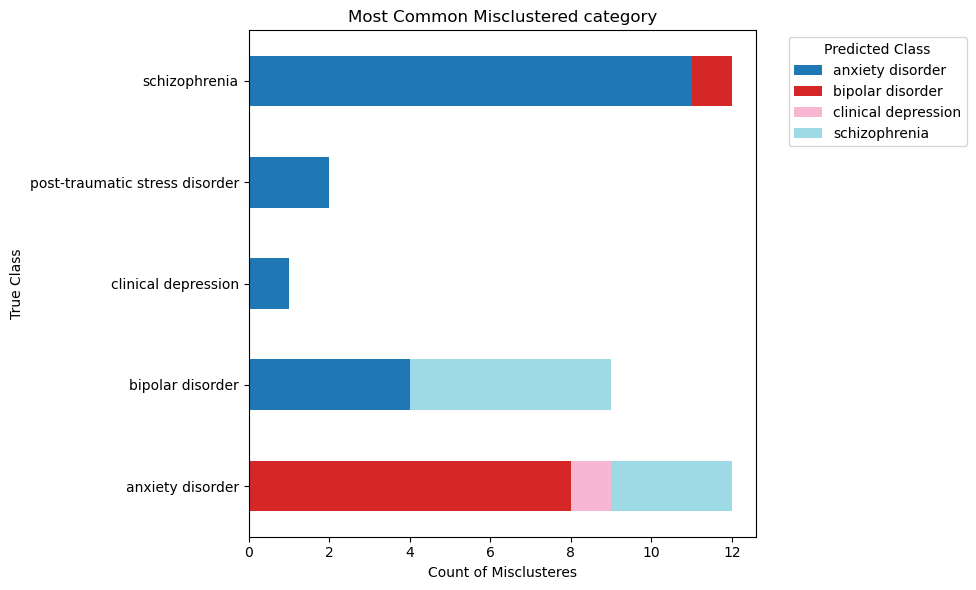

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Example mapping from numeric labels to actual category names
cluster_to_label = {
    0: "clinical depression",
    1: "bipolar disorder",
    2: "anxiety disorder",
    3: "post-traumatic stress disorder",
    4: "schizophrenia"
}

# 1. Filter the DataFrame to get only the misclassified rows
df_mis = df[df["Label_num"] != df["kmeans_aligned"]].copy()

# 2. Map numeric labels to descriptive names (if desired for readability)
df_mis["true_label_name"] = df_mis["Label_num"].map(cluster_to_label)
df_mis["predicted_label_name"] = df_mis["kmeans_aligned"].map(cluster_to_label)

# 3. Group by (true_label, predicted_label) to get misclassification counts
count_mis = (
    df_mis.groupby(["true_label_name", "predicted_label_name"])
    .size()
    .reset_index(name="count")
)

# 4. Pivot the data so that rows = true_label_name, columns = predicted_label_name, values = count
pivot_mis = count_mis.pivot(
    index="true_label_name",
    columns="predicted_label_name",
    values="count"
).fillna(0)

# 5. Plot a horizontal stacked bar chart
plt.figure(figsize=(10, 6))
pivot_mis.plot(
    kind="barh",
    stacked=True,
    ax=plt.gca(),
    cmap="tab20"  # Or another colormap of your choice
)

plt.xlabel("Count of Misclusteres")
plt.ylabel("True Class")
plt.title("Most Common Misclustered category")
plt.legend(title="Predicted Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


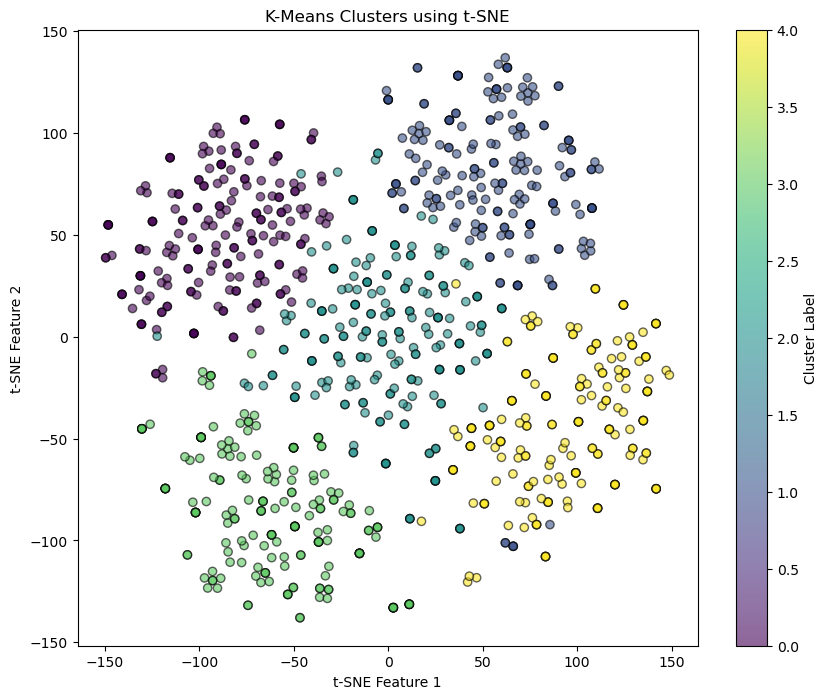

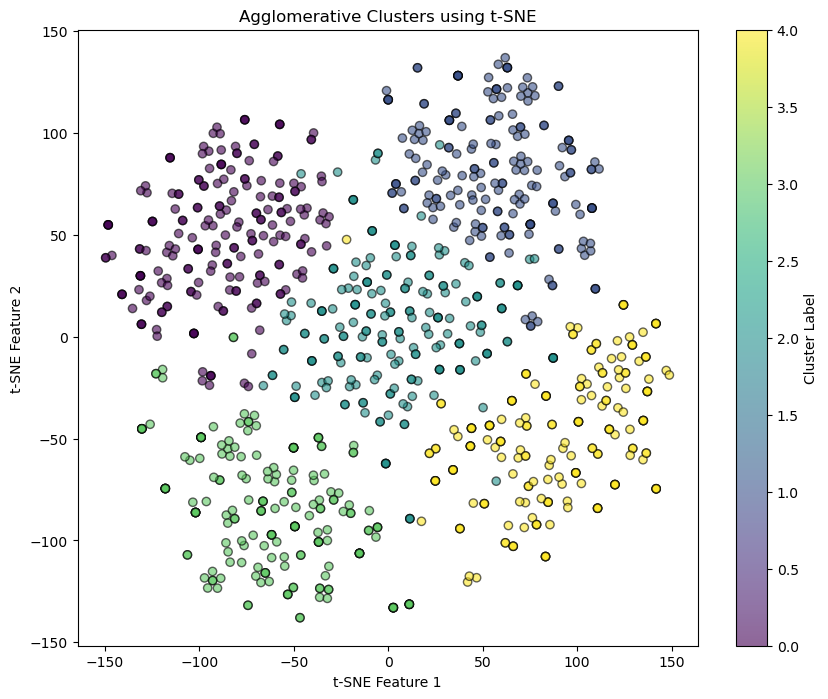

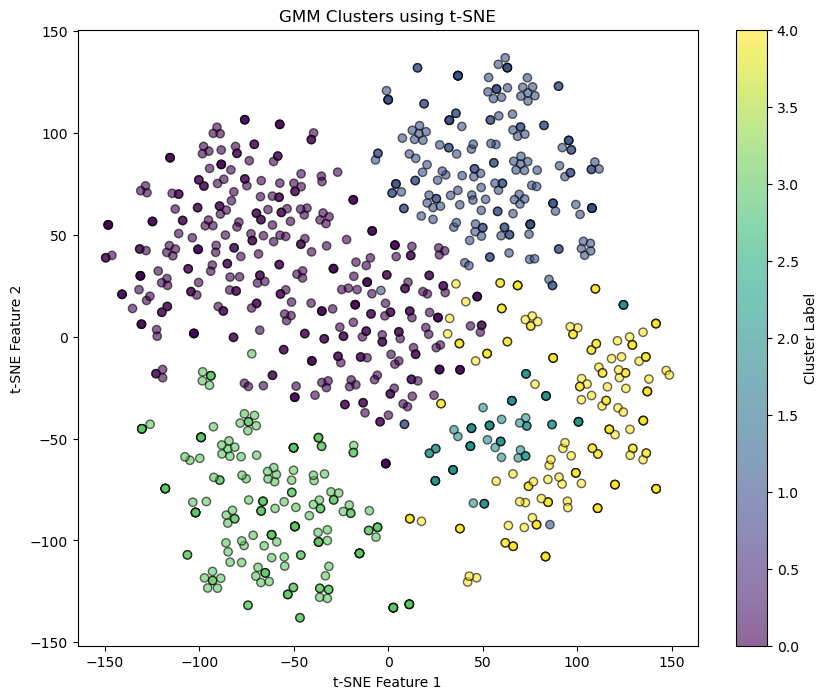

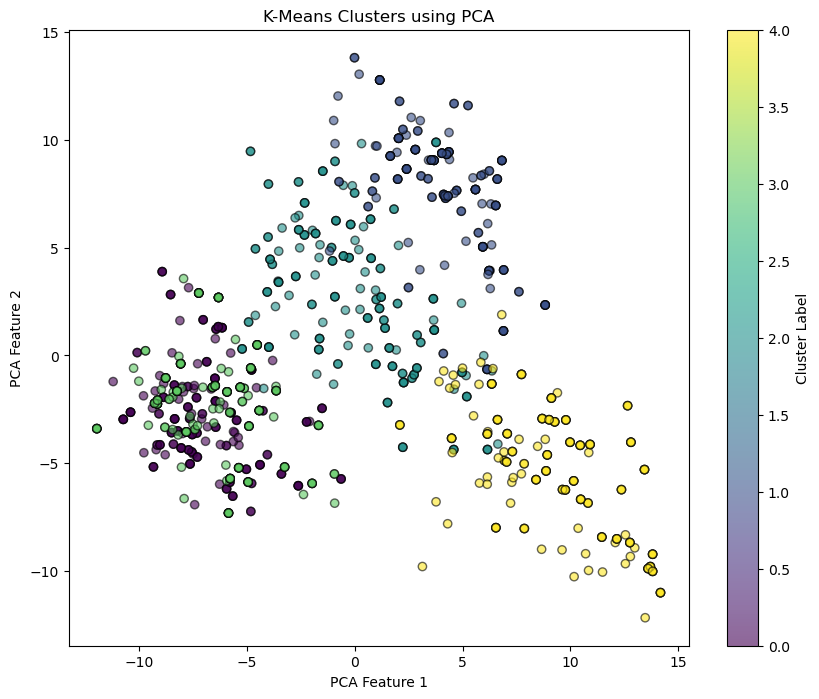

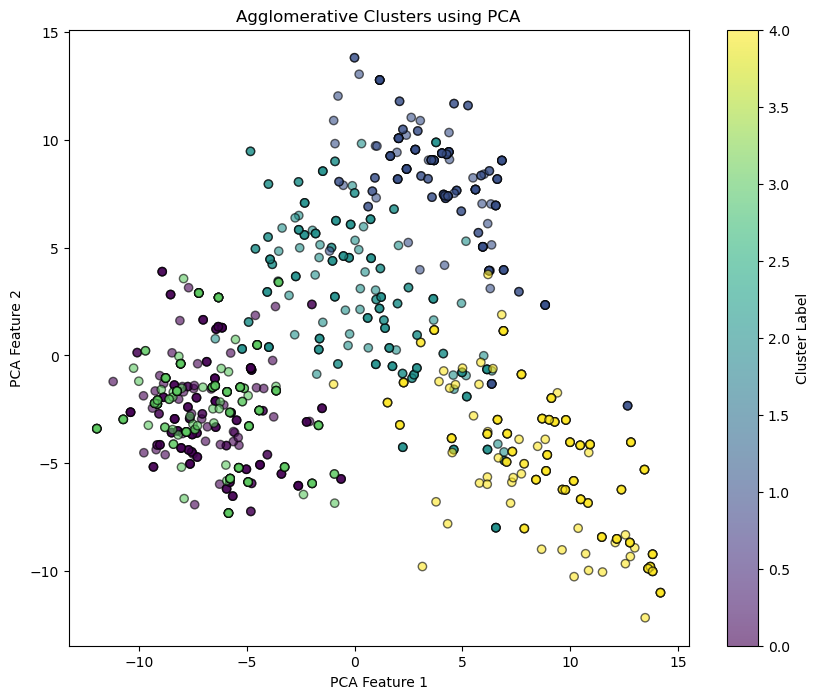

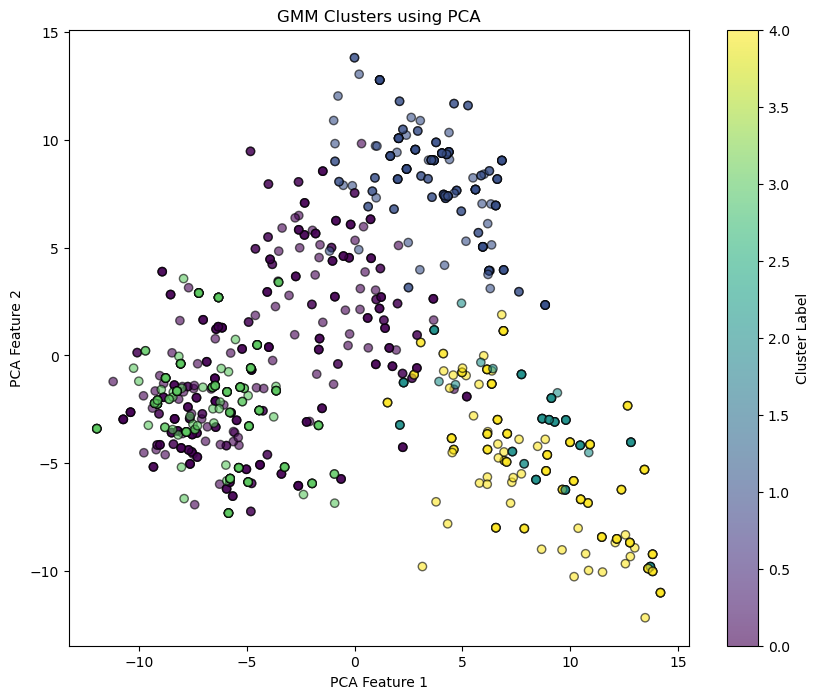

In [48]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, cohen_kappa_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import numpy as np

def plot_dimension_reduction(X, labels, title, method='t-SNE'):
    if method == 'PCA':
        reducer = PCA(n_components=2)
    else:
        reducer = TSNE(n_components=2, random_state=42)

    X_reduced = reducer.fit_transform(X)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=0.6, edgecolor='k')
    plt.colorbar(scatter, label='Cluster Label')
    plt.title(f'{title} using {method}')
    plt.xlabel(f'{method} Feature 1')
    plt.ylabel(f'{method} Feature 2')
    plt.show()

def plot_all_clusters(X_scaled, df):
    plot_dimension_reduction(X_scaled, df['kmeans_aligned'], 'K-Means Clusters')
    plot_dimension_reduction(X_scaled, df['agg_aligned'], 'Agglomerative Clusters')
    plot_dimension_reduction(X_scaled, df['gmm_aligned'], 'GMM Clusters')

    plot_dimension_reduction(X_scaled, df['kmeans_aligned'], 'K-Means Clusters', method='PCA')
    plot_dimension_reduction(X_scaled, df['agg_aligned'], 'Agglomerative Clusters', method='PCA')
    plot_dimension_reduction(X_scaled, df['gmm_aligned'], 'GMM Clusters', method='PCA')

# Assuming evaluate_clustering() has been called and df has been updated
plot_all_clusters(X_combined_scaled, df)


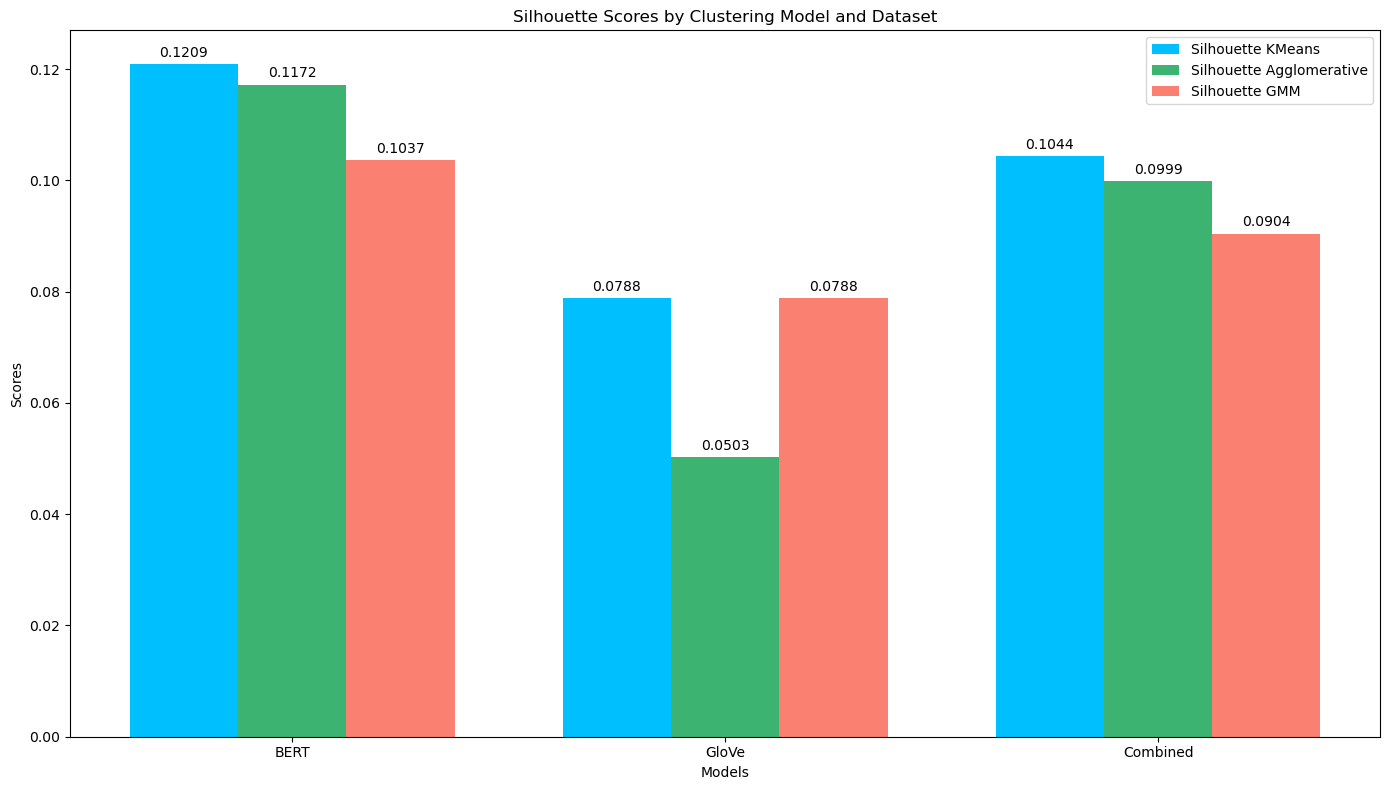

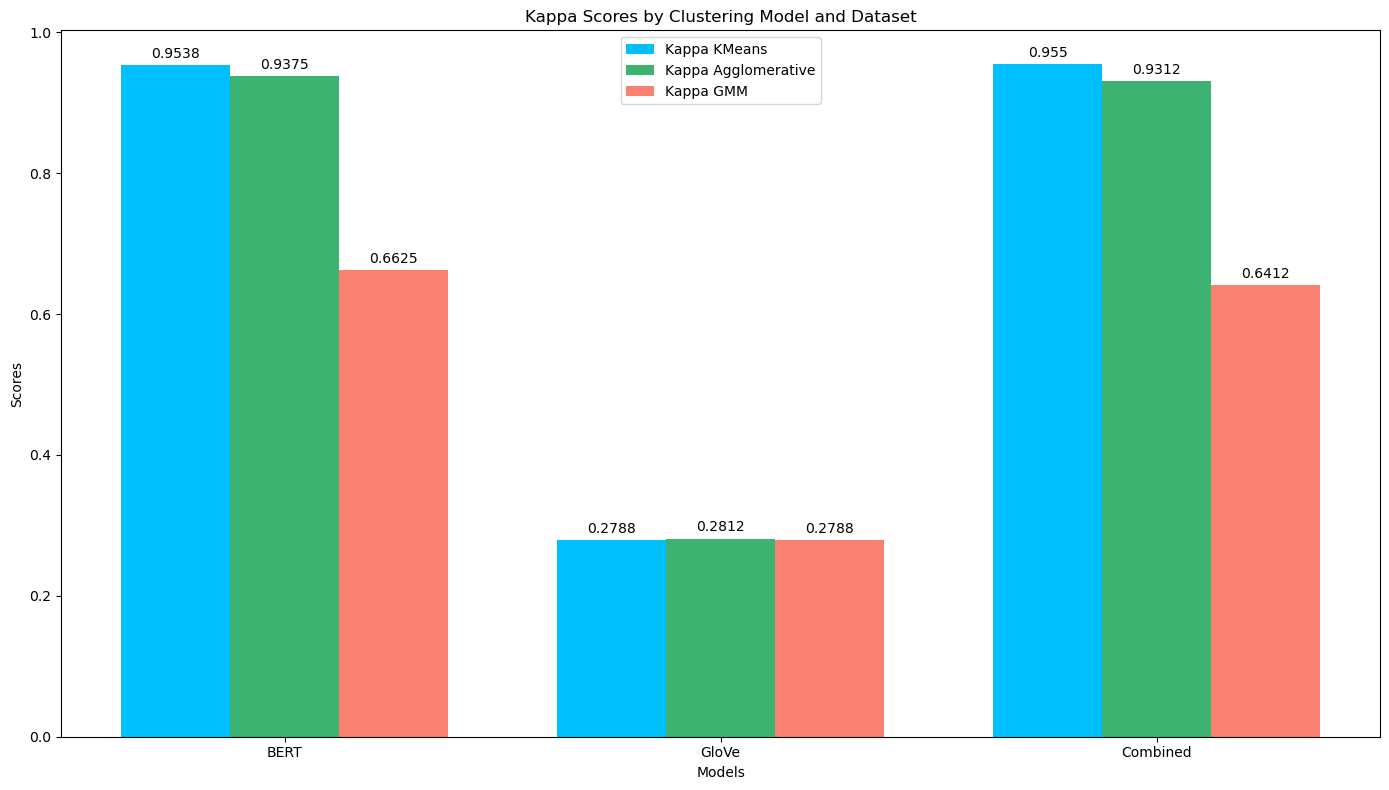

In [49]:
def plot_scores(results):
    # Create lists for the plot
    labels = list(results.keys())
    silhouette_kmeans = [results[model][0] for model in labels]
    silhouette_agg = [results[model][1] for model in labels]
    silhouette_gmm = [results[model][2] for model in labels]

    kappa_kmeans = [results[model][3] for model in labels]
    kappa_agg = [results[model][4] for model in labels]
    kappa_gmm = [results[model][5] for model in labels]

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - width, silhouette_kmeans, width, label='Silhouette KMeans', color='deepskyblue')
    rects2 = ax.bar(x, silhouette_agg, width, label='Silhouette Agglomerative', color='mediumseagreen')
    rects3 = ax.bar(x + width, silhouette_gmm, width, label='Silhouette GMM', color='salmon')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Silhouette Scores by Clustering Model and Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 4)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.tight_layout()

    # Kappa Scores Plot
    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - width, kappa_kmeans, width, label='Kappa KMeans', color='deepskyblue')
    rects2 = ax.bar(x, kappa_agg, width, label='Kappa Agglomerative', color='mediumseagreen')
    rects3 = ax.bar(x + width, kappa_gmm, width, label='Kappa GMM', color='salmon')

    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Kappa Scores by Clustering Model and Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.tight_layout()
    plt.show()

# Example call
plot_scores(results)


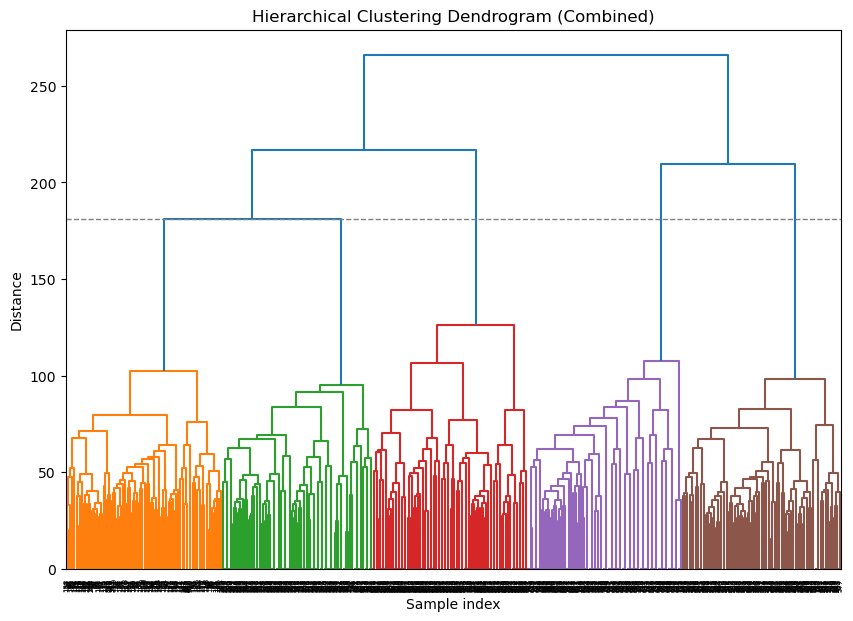

In [50]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

# Assume X_combined_scaled is already defined and scaled

# Perform hierarchical clustering using Ward's method
linked = linkage(X_combined_scaled, method='ward')

# Compute the threshold that gives exactly 5 clusters.
# One way is to take the (k-1)th largest distance:
k = 5
threshold = np.sort(linked[:, 2])[-(k - 1)]

# Plot the dendrogram with branches colored based on the threshold.
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           color_threshold=threshold)
plt.title('Hierarchical Clustering Dendrogram (Combined)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.axhline(y=threshold, c='grey', lw=1, linestyle='dashed')
plt.show()


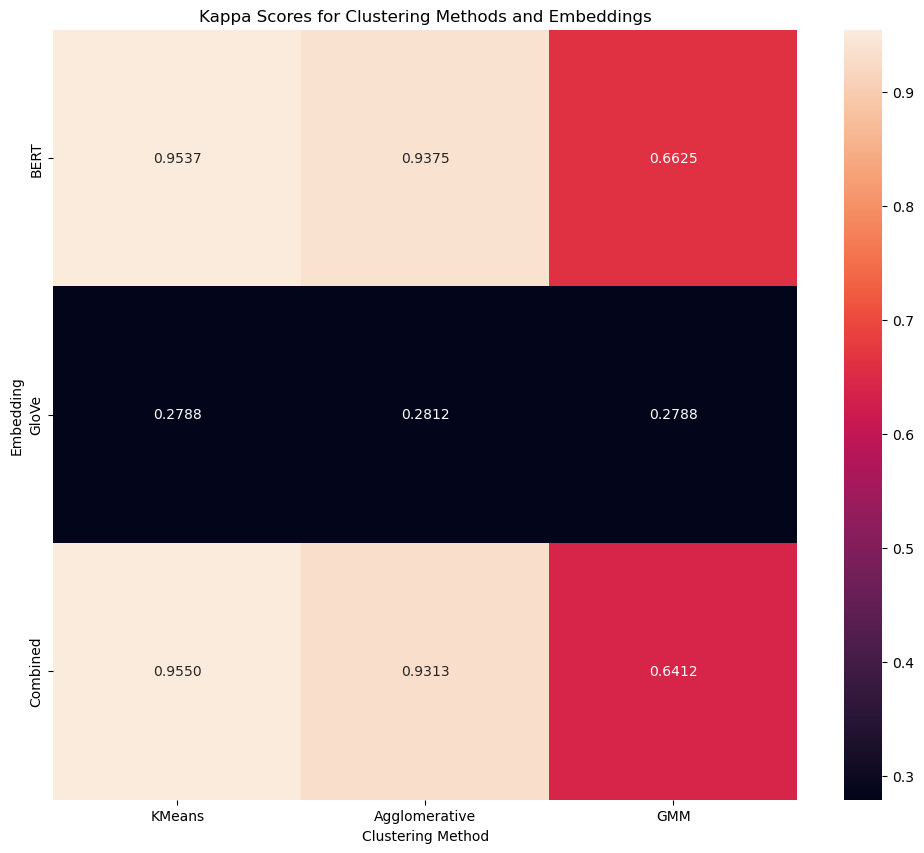

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Build a DataFrame from your results dictionary
# Assume your results dict is structured as:
# results[embedding] = (silhouette_kmeans, silhouette_agg, silhouette_gmm, kappa_kmeans, kappa_agg, kappa_gmm)
data = {
    "Embedding": [],
    "KMeans": [],
    "Agglomerative": [],
    "GMM": []
}

for embedding in results:
    data["Embedding"].append(embedding)
    data["KMeans"].append(results[embedding][3])
    data["Agglomerative"].append(results[embedding][4])
    data["GMM"].append(results[embedding][5])

df_kappa = pd.DataFrame(data).set_index("Embedding")

# Option 1: Heatmap Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(df_kappa, annot=True, fmt=".4f")
plt.title("Kappa Scores for Clustering Methods and Embeddings")
plt.ylabel("Embedding")
plt.xlabel("Clustering Method")
plt.show()




## Calculating and Plotting Coherence values

In [52]:
import gensim
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Function to process text for coherence calculation
def prepare_texts(df):
    return df["Abstract"].astype(str).apply(lambda x: x.lower().split()).tolist()

# Compute Coherence Scores
texts = prepare_texts(df)
dictionary = Dictionary(texts)

def compute_coherence(true_labels, predicted_labels, texts, dictionary):
    topics = [[word for word in texts[i] if word in dictionary.token2id] for i in predicted_labels]
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Compute coherence for each clustering model
coherence_scores = {
    'BERT': {},
    'GloVe': {},
    'Combined': {}
}

for model in results:
    coherence_scores[model]['KMeans'] = compute_coherence(df["Label_num"], df["kmeans_aligned"], texts, dictionary)
    coherence_scores[model]['Agglomerative'] = compute_coherence(df["Label_num"], df["agg_aligned"], texts, dictionary)
    coherence_scores[model]['GMM'] = compute_coherence(df["Label_num"], df["gmm_aligned"], texts, dictionary)

# Print coherence scores
print("\nCoherence Scores:")
for model in coherence_scores:
    print(f"\n{model}:")
    print(f"Coherence Score (KMeans): {coherence_scores[model]['KMeans']:.4f}")
    print(f"Coherence Score (Agglomerative): {coherence_scores[model]['Agglomerative']:.4f}")
    print(f"Coherence Score (GMM): {coherence_scores[model]['GMM']:.4f}")



Coherence Scores:

BERT:
Coherence Score (KMeans): 0.7066
Coherence Score (Agglomerative): 0.7052
Coherence Score (GMM): 0.6883

GloVe:
Coherence Score (KMeans): 0.7066
Coherence Score (Agglomerative): 0.7052
Coherence Score (GMM): 0.6883

Combined:
Coherence Score (KMeans): 0.7066
Coherence Score (Agglomerative): 0.7052
Coherence Score (GMM): 0.6883


In [ ]:
# Build a DataFrame from the computed coherence scores
data_coherence = {
    "Embedding": [],
    "KMeans": [],
    "Agglomerative": [],
    "GMM": []
}

for embedding in coherence_scores:
    data_coherence["Embedding"].append(embedding)
    data_coherence["KMeans"].append(coherence_scores[embedding]['KMeans'])
    data_coherence["Agglomerative"].append(coherence_scores[embedding]['Agglomerative'])
    data_coherence["GMM"].append(coherence_scores[embedding]['GMM'])

df_coherence = pd.DataFrame(data_coherence).set_index("Embedding")

# Plot Heatmap for Coherence Scores
plt.figure(figsize=(12, 10))
sns.heatmap(df_coherence, annot=True, fmt=".4f")
plt.title("Coherence Scores for Clustering Methods and Embeddings")
plt.ylabel("Embedding")
plt.xlabel("Clustering Method")
plt.show()

### Conclusion

Based on our evaluation metrics, the champion model is **Combined Embeddings + KMeans Clustering**. This model achieved the highest Cohen’s Kappa score, indicating strong agreement with the true labels, while also maintaining Coherence scores. In summary:

- **High Accuracy:** Combined embeddings with KMeans produced the most accurate clustering.
- **Semantic Consistency:** The coherence scores confirmed that clusters are semantically meaningful.
- **Robust Performance:** Overall, this model is well-suited for grouping mental health research abstracts effectively.

This champion model provides a reliable approach for automating literature organization and can significantly aid research in the mental health domain.